In [15]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import simulation as sim
import analysis
from scipy.optimize import curve_fit

def jackknife_batch_estimate(data,observable,k):
    '''Devide data into k batches and apply the function observable to each
    collection of all but one batches. Returns the mean and corrected
    standard error.'''
    batches = np.reshape(data,(k,-1))
    values = [observable(np.delete(batches,i,0).flatten()) for i in range(k)]
    return np.mean(values), np.sqrt(k-1)*np.std(values)

def linear_fit(beta, a, b):
    return a + b * beta

def rational_fit(beta, c):
    return 1/(c * beta)

def plot_and_fit_data(width,betas):
    action_averages = np.empty(len(betas))
    action_errors = np.empty(len(betas))
    num_batches = 50

    with h5py.File(f'data/action-per-beta_w{width}.hdf5','r') as f:
        for i,beta in enumerate(betas):
            actions = f[f"actions_b{np.round(beta,decimals=2)}"][()]
            action_estimate = jackknife_batch_estimate(actions,lambda x: np.mean(x),num_batches)
            action_averages[i] = action_estimate[0]
            action_errors[i] = action_estimate[1]

    linear_mask = (betas > 1) & (betas < 3.5)
    beta_linear = betas[linear_mask]
    mean_linear = np.array(action_averages)[linear_mask]

    linear_params, linear_cov = curve_fit(linear_fit, beta_linear, mean_linear)

    rational_mask = betas > 4.5
    beta_rational = betas[rational_mask]
    mean_rational = np.array(action_averages)[rational_mask]

    rational_params, rational_cov = curve_fit(rational_fit, beta_rational, mean_rational)

    linear_fit_vals = linear_fit(beta_linear, *linear_params)
    rational_fit_vals = rational_fit(beta_rational, *rational_params)

    plt.errorbar(betas, action_averages, action_errors, fmt='o', label='Data', color='blue', zorder=1)
    plt.plot(beta_linear, linear_fit_vals, label='Linear Fit', color='red', linewidth=2, zorder=3)
    plt.plot(beta_rational, rational_fit_vals, label='Rational Fit', color='green', linewidth=2, zorder=3)

    plt.xlabel(r'$\beta$', fontsize=12)
    plt.ylabel(r'$\langle E \rangle$', rotation=0, labelpad=15, fontsize=12)
    plt.title(fr'Average action per plaquette for width $w = {width}$')
    plt.legend()
    plt.show()

    print(f"Linear fit params: {linear_params} | Rational fit params: {rational_params}")

In [2]:
betas = np.arange(0.5,6,0.1)
widths = [4,5,6]

In [3]:
# collect and store data
measure_sweeps = [7500,6000,3000]

for i,width in enumerate(widths):
    for beta in betas:
        analysis.try_gather_data(state=sim.ordered_state(width=width),beta=beta,k=0,n=1,measurements=measure_sweeps[i])

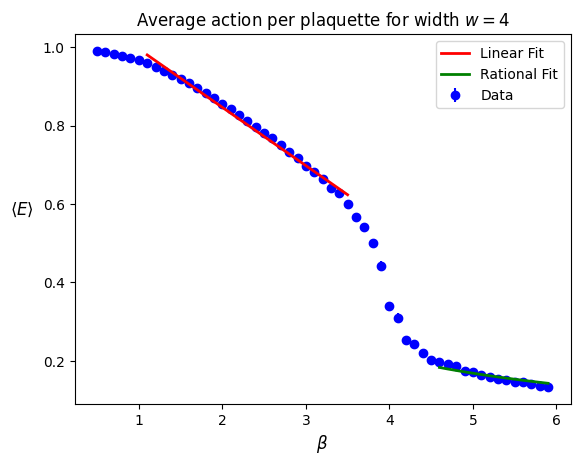

Linear fit params: [ 1.14382199 -0.14857895] | Rational fit params: [1.18606166]


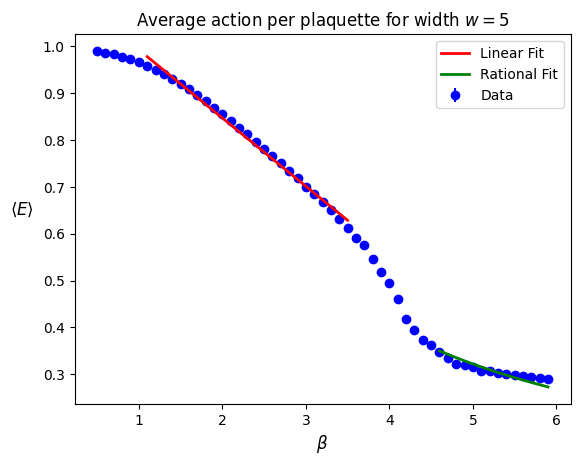

Linear fit params: [ 1.13844251 -0.14564007] | Rational fit params: [0.62107441]


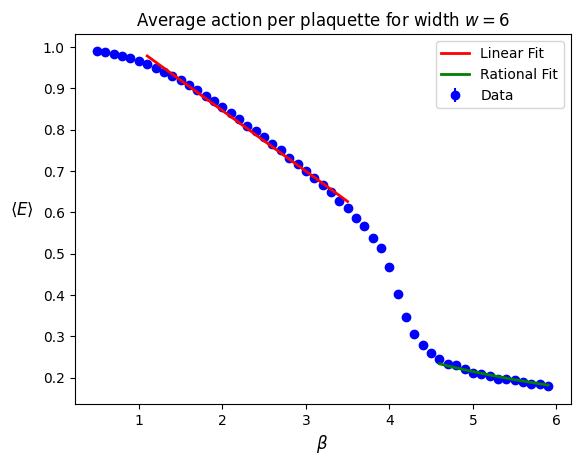

Linear fit params: [ 1.13964596 -0.14668509] | Rational fit params: [0.93086852]


In [16]:
# plot data
for width in widths:
    plot_and_fit_data(width,betas)